## Import data

In [111]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import linear_rainbow
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor

from custom_functions import *

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Import dataset that was cleaned and prepared in Data Preparation notebook

In [60]:
conn = sqlite3.connect('../../data/processed/main.db')
query = '''SELECT * FROM step2_encoded'''
df_main = pd.read_sql(query, conn, index_col='index').reset_index(drop=True)
conn.close()

y = 'SalePrice'

# One-hot encode categoricals

#### Encode "HeatSystem"

In [61]:
# First, convert encoded values to text values so we can understand their meaning
keys = get_lookups(108)
print('Keys:', keys, '\n')
convert_to_keys = lambda x: keys[str(int(x))].replace(" ", "").replace('-','') if x!='0' else 'Other'
heating = df_main.HeatSystem.apply(convert_to_keys)
print('Original breakdown:\n{}'.format(heating.value_counts()))

# We see that Gravity and Radiant are very uncommon. Let's lump them into the "Other" category
simplify = lambda x: 'Other' if x in ['Gravity', 'Radiant'] else x
heating = heating.apply(simplify)
print('\nImproved categorization:\n{}'.format(heating.value_counts()))

# Now that we have appropriate categorization, let's one-hot encode
heating_dummies = pd.get_dummies(heating, prefix='Heating', drop_first=False).drop('Heating_ForcedAir', axis=1) # Choose to drop ForcedAir

#Adjust df_main accordingly
df_main.drop('HeatSystem', axis=1, inplace=True)
df_main = pd.concat([df_main, heating_dummies], axis=1)

Keys: {'1': 'Floor-Wall', '2': 'Gravity', '3': 'Radiant', '4': 'Elec BB', '5': 'Forced Air', '6': 'Hot Water', '7': 'Heat Pump', '8': 'Other'} 

Original breakdown:
ForcedAir    14148
HeatPump      1536
ElecBB        1124
FloorWall      564
HotWater       447
Radiant        261
Gravity         38
Other           25
Name: HeatSystem, dtype: int64

Improved categorization:
ForcedAir    14148
HeatPump      1536
ElecBB        1124
FloorWall      564
HotWater       447
Other          324
Name: HeatSystem, dtype: int64


#### Encode "Condition"

In [62]:
keys = get_lookups(83)
print('Keys:', keys)
convert_to_keys = lambda x: keys[x].replace(' ', '')
condition = df_main.Condition.apply(convert_to_keys)
print('\nBreakdown of conditions:\n{}'.format(condition.value_counts()))

condition_dummies = pd.get_dummies(condition, prefix='Condition', drop_first=False).drop('Condition_Average', axis=1)
df_main.drop('Condition', axis=1, inplace=True)
df_main = pd.concat([df_main, condition_dummies], axis=1)

Keys: {'1': 'Poor', '2': 'Fair', '3': 'Average', '4': 'Good', '5': 'Very Good'}

Breakdown of conditions:
Average     11384
Good         4716
VeryGood     1915
Fair          115
Poor           13
Name: Condition, dtype: int64


#### Encode "HeatSource"

In [63]:
keys = get_lookups(84)
apply_keys = lambda x: keys[x] if x!='0' else 'Other'
heat_source = df_main.HeatSource.apply(apply_keys)
print()
print('Original breakdown:\n{}'.format(heat_source.value_counts()))

# Now, combine the extremely small categories into an 'Other' bucket
simplify = lambda x: 'Other' if x in ['Gas/Solar', 'Electricity/Solar', 'Oil/Solar'] else x
heat_source = heat_source.apply(simplify)
print('\nImproved categorization:\n{}'.format(heat_source.value_counts()))

heat_source_dummies = pd.get_dummies(heat_source, prefix='HeatSource', drop_first=False).drop('HeatSource_Gas', axis=1)

# Adjust df_main with results
df_main.drop('HeatSource', axis=1, inplace=True)
df_main = pd.concat([df_main, heat_source_dummies], axis=1)


Original breakdown:
Gas                  13138
Electricity           3186
Oil                   1738
Gas/Solar               40
Other                   31
Electricity/Solar        8
Oil/Solar                2
Name: HeatSource, dtype: int64

Improved categorization:
Gas            13138
Electricity     3186
Oil             1738
Other             81
Name: HeatSource, dtype: int64


#### Encode porch metrics

By default, the information given about porches is given in square feet. Instead of looking at the impact of porch size, we will investigate whether the presence of a deck impacts SalePrice

Encode as either enclosed, open, both, or neither. The default will be "neither", and as a result we will drop that column once encoded.

In [64]:
porches = df_main[['SqFtOpenPorch', 'SqFtEnclosedPorch']].copy()
porches.columns = ['Open', 'Encl']

classify_porches = lambda x: 'Both' if ((x.Open>0)&(x.Encl>0)) else 'Open' if x.Open>0 else 'Closed' if x.Encl>0 else 'None'

porches['Simplified'] = porches.apply(classify_porches, axis=1)
porches

porches_dummies = pd.get_dummies(porches.Simplified, prefix='Porch', drop_first=False).drop('Porch_None', axis=1)


df_main = pd.concat([df_main, porches_dummies], axis=1)
df_main.drop(['SqFtOpenPorch', 'SqFtEnclosedPorch'], axis=1, inplace=True)

# Step-wise feature selection: remove features with low p-value

In [80]:
# Run Step-wise selection algorithm to eliminate irrelevant features
X = df_main.drop(y, axis=1)
keepers = stepwise_selection(X, df_main[y], verbose=True)

# Determine which features were removed
removed = list(df_main.drop(y, axis=1).columns)
for item in keepers:
    removed.remove(item)

print('\nRemaining features:', keepers)
print('\nRemoved features:', removed)


df_removed = df_main[removed].copy()

df_main = df_main[[y] + keepers].copy()

Add  Bathrooms                      with p-value 0.0
Add  SqFtTotLiving                  with p-value 0.0
Add  BldgGrade                      with p-value 0.0
Add  YrBuilt                        with p-value 0.0
Add  Bedrooms                       with p-value 1.56554e-119
Add  SqFtGarageAttached             with p-value 3.09236e-91
Add  YrRenovated                    with p-value 2.17328e-09
Add  Heating_HotWater               with p-value 3.53294e-08
Add  Heating_FloorWall              with p-value 1.88038e-06
Add  Heating_ElecBB                 with p-value 1.30417e-06
Add  Heating_Other                  with p-value 5.0394e-07
Add  HeatSource_Other               with p-value 4.60187e-05
Add  Condition_VeryGood             with p-value 0.000209514
Add  HeatSource_Oil                 with p-value 0.000583019
Add  Heating_HeatPump               with p-value 0.000507457
Add  HeatSource_Electricity         with p-value 0.00245621

Remaining features: ['Bathrooms', 'SqFtTotLiving', 'Bldg

# Gain graphical understanding of data

C:\Users\seths\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


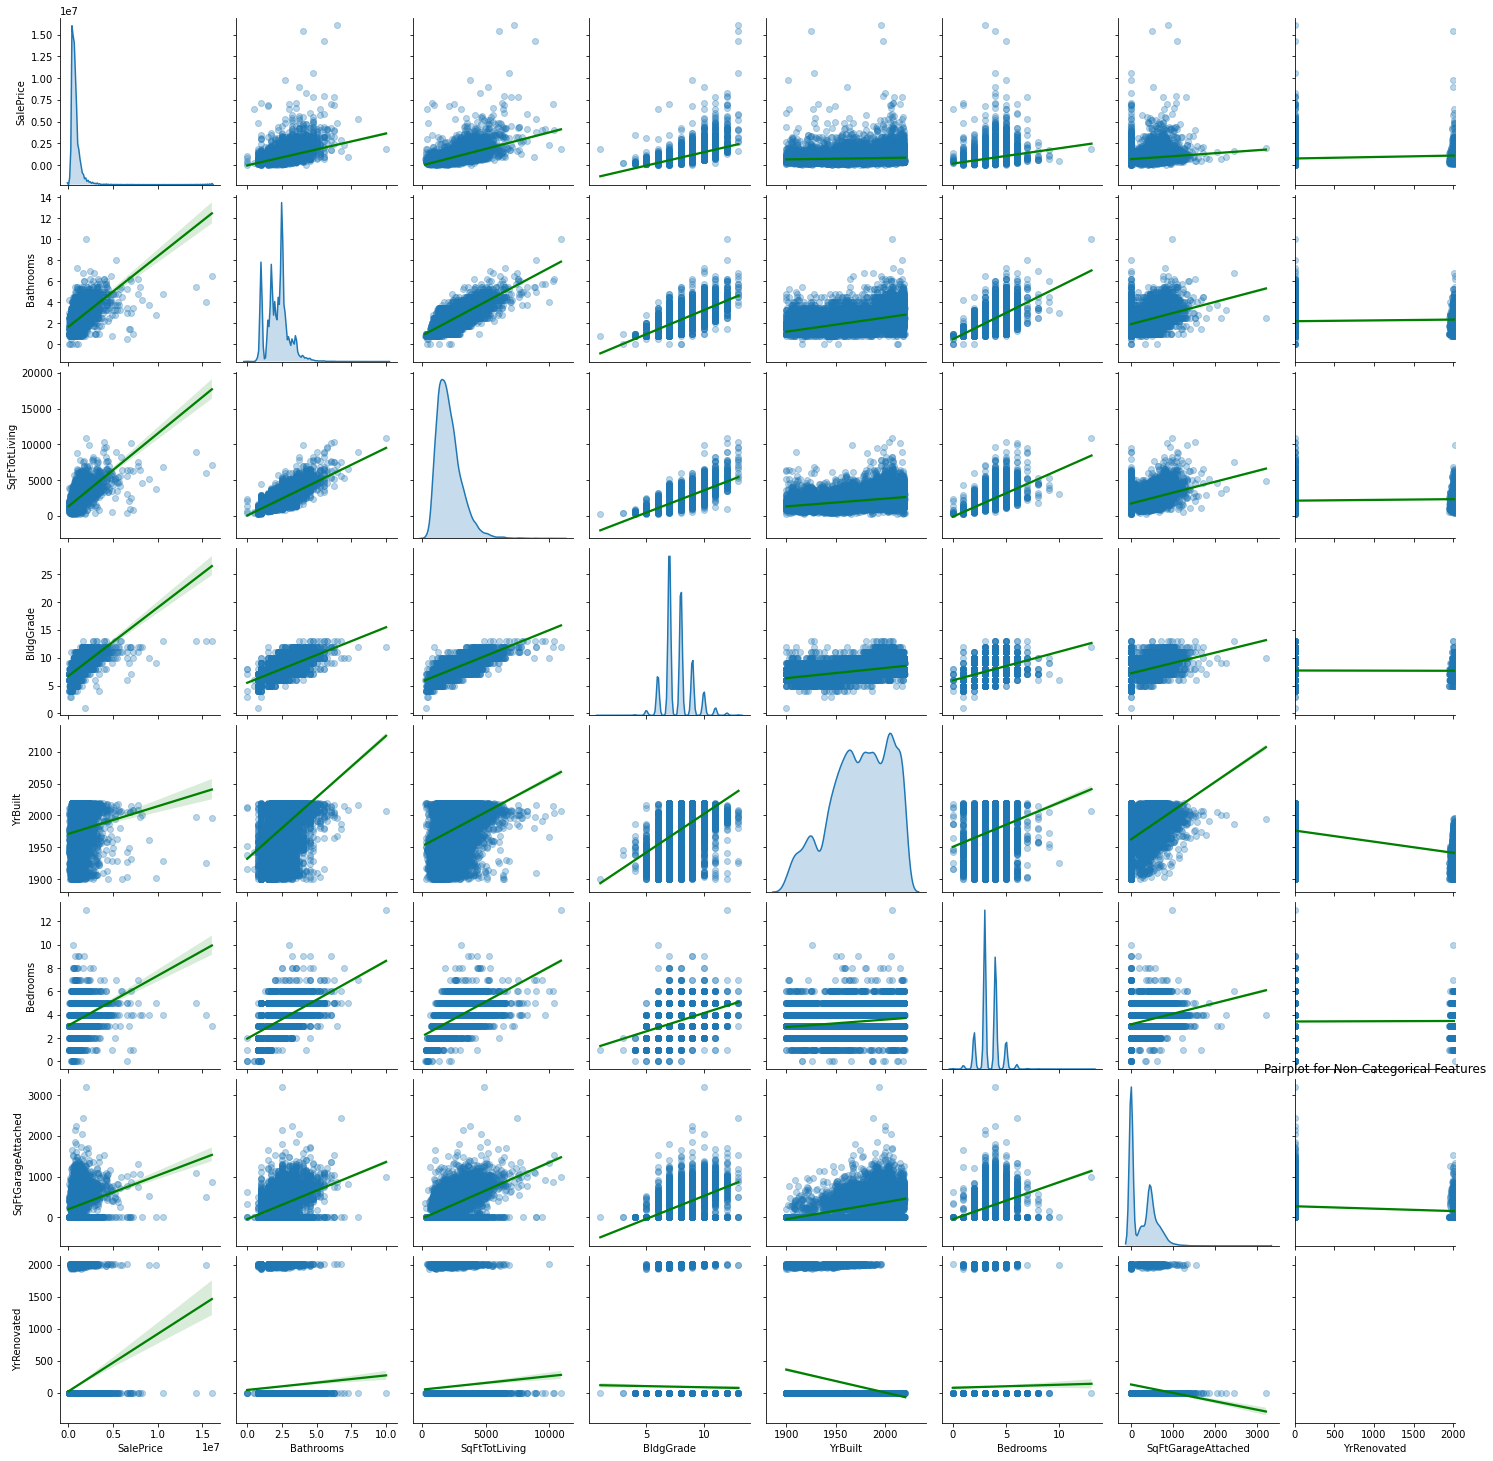

In [101]:
sns.pairplot(df_main.iloc[:, :8], kind='reg', diag_kind='kde', plot_kws={'line_kws':{'color':'g'}, 'scatter_kws': {'alpha': 0.3}})
plt.title('Pairplot for Non-Categorical Features', y=-10);

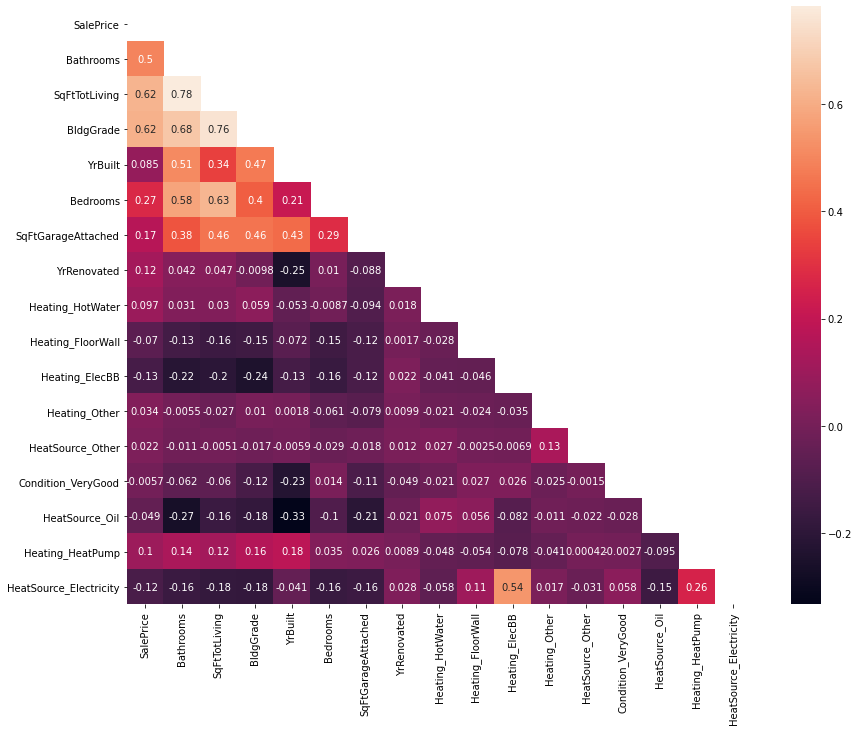

In [98]:
corr = df_main.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool)) # Formula taken from Flatiron School study group material
fig1, ax1 = plt.subplots(figsize=(14, 11))
sns.heatmap(corr, mask=mask, ax=ax1, annot=True);

# Create the single-variable model

#### Start with the feature showing the largest correlation with SalePrice

In [106]:
correlations = df_main.corr().stack().reset_index()
correlations = correlations.loc[(correlations.level_0 == 'SalePrice') & (correlations.level_1 != 'SalePrice')]
correlations.columns = ['Dependent', 'Feature', 'Correlation (abs)']
correlations['Correlation (abs)'] = correlations['Correlation (abs)'].abs()

correlations.sort_values(by='Correlation (abs)', ascending=False, inplace=True, ignore_index=True)
correlations

,Dependent,Feature,Correlation (abs)
0,SalePrice,SqFtTotLiving,0.622001
1,SalePrice,BldgGrade,0.615589
2,SalePrice,Bathrooms,0.496065
3,SalePrice,Bedrooms,0.273957
4,SalePrice,SqFtGarageAttached,0.168159
5,SalePrice,Heating_ElecBB,0.126977
6,SalePrice,YrRenovated,0.122163
7,SalePrice,HeatSource_Electricity,0.115226
8,SalePrice,Heating_HeatPump,0.099614
9,SalePrice,Heating_HotWater,0.097147


#### Not surprisingly, the livable square footage is amongst the highest predictors

Let's create the simple model and check the assumptions of Linear Regression

Modeling: SalePrice ~ SqFtTotLiving 

Linearity p-value (where null hypothesis = linear): 2.3498371777527503e-05
Normality of Residuals (where null hypothesis = normality): JB stat=13052071.633737946, JB stat p-value=0.0
Homoscedacity (where null hypothesis = homoscedastic): lagrange p-value=9.69930890498894e-96 and f-value's p-value=7.370337506432815e-97
Variance Inflation Factor: NA (single variable)


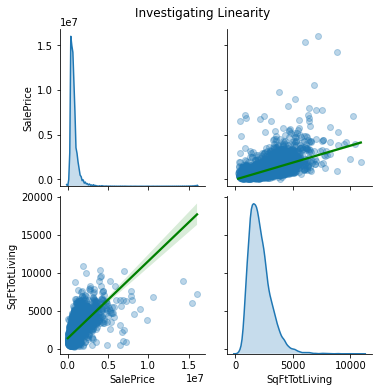

In [128]:
features = ['SqFtTotLiving']
model, df_model = produce_model(df_main, features)
check_assumptions(model, df_model, feature_to_plot=features[0])

#### Clearly, neither SalePrice or SqFtTotLiving are linear. Let's log-transform and see the effect

# Check Assumptions

In [33]:
#features = df_main.drop([y, 'SqFtTotLiving', 'BldgGrade', 'YrBuilt'], axis=1).columns
#features = df_main.drop([y, 'SqFtTotLiving', 'BldgGrade', 'YrBuilt'], axis=1).columns
#features = ['SqFtTotLiving', 'YrBuilt']
model, df_model = produce_model(df_main, features, cols_to_clean=['SalePrice'])
check_assumptions(model, df_model, feature_to_plot=['SalePrice'])

Modeling: SalePrice ~ SqFtGarageAttached+Bathrooms+SqFtOpenPorch+YrRenovated+Heating_HotWater+Heating_FloorWall+Heating_Other+Heating_ElecBB+HeatSource_Other+Condition_VeryGood+HeatSource_Oil+Heating_HeatPump+HeatSource_Electricity+SqFtDeck 

Linearity p-value (where null hypothesis = linear): 0.010948559647351731
Normality of Residuals (where null hypothesis = normality): JB stat=8924.592735941702, JB stat p-value=0.0
Homoscedacity (where null hypothesis = homoscedastic): lagrange p-value=0.0 and f-value's p-value=0.0

Variance Inflation Factors:
                    Feature       VIF
0       SqFtGarageAttached  2.352751
1                Bathrooms  3.703753
2            SqFtOpenPorch  1.335935
3              YrRenovated  1.070126
4         Heating_HotWater  1.050494
5        Heating_FloorWall  1.083487
6            Heating_Other  1.051794
7           Heating_ElecBB  1.680360
8         HeatSource_Other  1.024342
9       Condition_VeryGood  1.119244
10          HeatSource_Oil  1.089679
1

In [19]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.569
Model:                            OLS   Adj. R-squared:                  0.569
Method:                 Least Squares   F-statistic:                     1304.
Date:                Mon, 08 Mar 2021   Prob (F-statistic):               0.00
Time:                        17:38:14   Log-Likelihood:            -2.4636e+05
No. Observations:               17792   AIC:                         4.928e+05
Df Residuals:                   17773   BIC:                         4.929e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               5.542e+06   1.72e+05     32.252      0.000    5.21e+06    5.88e+06
SqFtTotLiving            149.1842      4.332     34.438      0.000     140.693     157.675
BldgGrade               1.791e+05   2766.383     64.751      0.000    1.74e+05    1.85e+05
YrBuilt                -3272.5232     89.604    -36.522      0.000   -3448.156   -3096.891
SqFtGarageAttached      -179.6302      8.075    -22.246      0.000    -195.457    -163.803
Bedrooms               -3.996e+04   2788.969    -14.326      0.000   -4.54e+04   -3.45e+04
Bathrooms               6.087e+04   4443.749     13.699      0.000    5.22e+04    6.96e+04
SqFtOpenPorch            114.4189     14.072      8.131      0.000      86.836     142.002
YrRenovated               29.0140      4.741      6.120      0.000      19.722      38.306
Heating_HotWater        5.389e+04   1.26e+04      4.267      0.000    2.91e+04    7.87e+04
Heating_FloorWall       5.267e+04   1.12e+04      4.720      0.000    3.08e+04    7.45e+04
Heating_Other           1.041e+05   1.45e+04      7.175      0.000    7.57e+04    1.33e+05
Heating_ElecBB          5.134e+04   9844.034      5.216      0.000     3.2e+04    7.06e+04
HeatSource_Other         9.13e+04   2.87e+04      3.184      0.001    3.51e+04    1.47e+05
Condition_VeryGood      3.357e+04   6403.754      5.243      0.000     2.1e+04    4.61e+04
HeatSource_Oil          1.326e+04   7044.839      1.882      0.060    -552.755    2.71e+04
Heating_HeatPump        5.995e+04   7591.741      7.896      0.000    4.51e+04    7.48e+04
HeatSource_Electricity -3.987e+04   6553.732     -6.083      0.000   -5.27e+04    -2.7e+04
SqFtDeck                  52.6031      9.474      5.553      0.000      34.034      71.172
==============================================================================
Omnibus:                     3371.685   Durbin-Watson:                   1.775
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11977.288
Skew:                           0.934   Prob(JB):                         0.00
Kurtosis:                       6.559   Cond. No.                     2.73e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.73e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

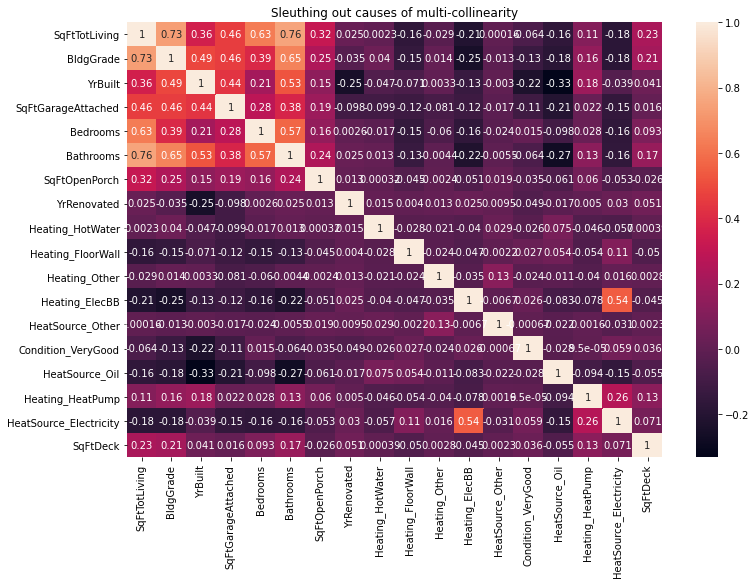

In [15]:
CorrMatrix = df_model.drop([y], axis=1).corr()
plt.figure(figsize=(12,8))
sns.heatmap(CorrMatrix, annot=True)
plt.title('Sleuthing out causes of multi-collinearity');

## Figure out how to achieve a low VIF

In [29]:
(df_model.YrRenovated>0).value_counts()

False    16959
True       833
Name: YrRenovated, dtype: int64

In [17]:
includes = df_model.columns#['YrBuilt', 'Bedrooms', 'SqFtOpenPorch']
vif = pd.DataFrame()
vif['VIF Factor'] = [variance_inflation_factor(df_model[includes].values, i) for i in range(df_model[includes].shape[1])]
vif["features"] = df_model[includes].columns
vif

,VIF Factor,features
0,10.534790,SalePrice
1,29.455207,SqFtTotLiving
2,154.136202,BldgGrade
3,110.289305,YrBuilt
4,2.788265,SqFtGarageAttached
5,27.608179,Bedrooms
6,25.620725,Bathrooms
7,1.406164,SqFtOpenPorch
8,1.091962,YrRenovated
9,1.061383,Heating_HotWater


In [18]:
drops = ['YrRenovated', 'SalePrice']

vif = pd.DataFrame()
X_drops = df_model.drop(drops, axis=1)
vif["VIF Factor"] = [variance_inflation_factor(X_drops.values, i) for i in range(X_drops.shape[1])]
vif["features"] = X_drops.columns
vif

,VIF Factor,features
0,27.084000,SqFtTotLiving
1,128.276747,BldgGrade
2,100.684563,YrBuilt
3,2.611005,SqFtGarageAttached
4,27.417584,Bedrooms
5,25.603788,Bathrooms
6,1.401604,SqFtOpenPorch
7,1.059777,Heating_HotWater
8,1.119179,Heating_FloorWall
9,1.063007,Heating_Other
